# Proyecto final: Desarrollo de un modelo de predicción de insuficiencia renal aguda causada por rabdomiólisis. 

#### Grupo A: Marc Palomer, June Alberdi,Yanelky Fabián & Miranda Silveria 
#### Clínico Supervisor: Dr. Guido Muñoz

##### Organización y gestión de la Información y Conocimientos Clínicos Máster en Ingeniería Biomédica UB/UPC - 2022/2023

### 1. Acceso a los datos

In [1]:
#Importar librerías
import pandas as pd
import numpy as np
import time 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from google.oauth2 import service_account
from google.cloud import bigquery
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from google.oauth2 import service_account
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import pickle

In [2]:
# Definir credenciales
credentials = service_account.Credentials.from_service_account_file("C:/Users/34668/OneDrive/Escritorio/MIMIC/MIMIC/credentials.json")

In [3]:
# Configurar el cliente de Big Query
client = bigquery.Client(credentials=credentials)

In [4]:
# Definir datasets
hosp_dataset_id = 'mimicIV_hosp'
icu_dataset_id = 'mimicIV_icu'

#Definir tablas
admissions_table = 'admissions'
patients_table = 'patients'
d_items_table = 'd_items'
icustays_table = 'icustays'
chartevents_table = 'chartevents'
labevents_table = 'labevents'
procedureevents_table = 'procedureevents'
diagnoses = 'diagnoses_icd'

In [5]:
#Creatina cinasa
d_labitems = "d_labitems"
query_codes = f"SELECT * FROM {hosp_dataset_id}.{d_labitems} WHERE LOWER(label) LIKE '%creati%' AND fluid = 'Blood'"# OR LOWER(label) LIKE '%potassium%' OR LOWER(label) LIKE '%ph%'"

#Guardamos códigos:
labcodes = client.query(query_codes).to_dataframe()
labcodes

,itemid,label,fluid,category
0,52024,"Creatinine, Whole Blood",Blood,Blood Gas
1,50910,Creatine Kinase (CK),Blood,Chemistry
2,50911,"Creatine Kinase, MB Isoenzyme",Blood,Chemistry
3,50912,Creatinine,Blood,Chemistry
4,51594,"Creatine Kinase, Isoenzyme BB",Blood,Chemistry
5,51595,"Creatine Kinase, Isoenzyme MB",Blood,Chemistry
6,51596,"Creatine Kinase, Isoenzyme MM",Blood,Chemistry
7,52546,Creatinine,Blood,Chemistry


In [6]:
#Potasio: 
d_labitems = "d_labitems"
query_codes = f"SELECT * FROM {hosp_dataset_id}.{d_labitems} WHERE (LOWER(label) LIKE '%potassium%' OR LOWER(label) LIKE '%K+%' OR LOWER(label) LIKE '%K%') AND fluid = 'Blood'"

labcodes = client.query(query_codes).to_dataframe()

#Guardamos códigos:
potassiumid = list(labcodes.itemid)
labcodes

,itemid,label,fluid,category
0,50822,"Potassium, Whole Blood",Blood,Blood Gas
1,52452,"Potassium, Whole Blood",Blood,Blood Gas
2,50971,Potassium,Blood,Chemistry
3,52610,Potassium,Blood,Chemistry


In [7]:
#PH
d_labitems = "d_labitems"
query_codes = f"SELECT * FROM {hosp_dataset_id}.{d_labitems} WHERE LOWER(label) LIKE 'p_%' AND LENGTH(label) = 2"

labcodes = client.query(query_codes).to_dataframe()

#Guardamos códigos:
phid = list(labcodes.itemid)
labcodes

,itemid,label,fluid,category
0,52041,pH,Fluid,Blood Gas
1,50820,pH,Blood,Blood Gas
2,50831,pH,Other Body Fluid,Blood Gas
3,51094,pH,Urine,Chemistry
4,52730,pH,Urine,Chemistry
5,51274,PT,Blood,Hematology
6,52921,PT,Blood,Hematology
7,51491,pH,Urine,Hematology


In [8]:
#Diabetes
diagnoses = "d_icd_diagnoses"
query_codes = f"SELECT * FROM {hosp_dataset_id}.{diagnoses} WHERE LOWER(long_title) LIKE '%diabetes%'"

diagnosticcodes = client.query(query_codes).to_dataframe()
print(diagnosticcodes.shape)

#Guardamos códigos:
diab_codes = diagnosticcodes.icd_code
list(diab_codes)
diagnosticcodes


(714, 3)


,icd_code,icd_version,long_title
0,24900,9,Secondary diabetes mellitus without mention of...
1,24901,9,Secondary diabetes mellitus without mention of...
2,24910,9,"Secondary diabetes mellitus with ketoacidosis,..."
3,24911,9,"Secondary diabetes mellitus with ketoacidosis,..."
4,24920,9,Secondary diabetes mellitus with hyperosmolari...
...,...,...,...
709,P702,10,Neonatal diabetes mellitus
710,R7303,10,Prediabetes
711,Z131,10,Encounter for screening for diabetes mellitus
712,Z833,10,Family history of diabetes mellitus


In [9]:
#Insuficiencia renal aguda 
diagnoses = "d_icd_diagnoses"
query_codes = f"SELECT * FROM {hosp_dataset_id}.{diagnoses} WHERE LOWER(long_title) LIKE 'acute kidney%'"

insufcodes = client.query(query_codes).to_dataframe()
print(insufcodes.shape)

#Guardamos códigos:
insuf_codes= list(insufcodes.icd_code)
insufcodes.head(5)
insufcodes


(13, 3)


,icd_code,icd_version,long_title
0,5845,9,Acute kidney failure with lesion of tubular ne...
1,5846,9,Acute kidney failure with lesion of renal cort...
2,5847,9,Acute kidney failure with lesion of renal medu...
3,5848,9,Acute kidney failure with other specified path...
4,5849,9,"Acute kidney failure, unspecified"
5,66930,9,Acute kidney failure following labor and deliv...
6,66932,9,Acute kidney failure following labor and deliv...
7,66934,9,Acute kidney failure following labor and deliv...
8,N17,10,Acute kidney failure
9,N170,10,Acute kidney failure with tubular necrosis


In [10]:
#Insuficiencia renal crónica:
diagnoses = "d_icd_diagnoses"
query_codes = f"SELECT * FROM {hosp_dataset_id}.{diagnoses} WHERE LOWER(long_title) LIKE 'chronic kidney%'"

cronicinsufcodes = client.query(query_codes).to_dataframe()
print(cronicinsufcodes.shape)

#Guardamos códigos:
cronicinsuf_codes= list(cronicinsufcodes.icd_code)
cronicinsufcodes.head(5)
cronicinsuf_codes

(13, 3)


['5851',
 '5852',
 '5853',
 '5854',
 '5855',
 '5859',
 'N18',
 'N181',
 'N182',
 'N183',
 'N184',
 'N185',
 'N189']

In [11]:
#Rabdomiólisis:
diagnoses = "d_icd_diagnoses"
query_codes = f"SELECT * FROM {hosp_dataset_id}.{diagnoses} WHERE LOWER(long_title) LIKE 'rhab%'"

#Guardamos códigos:
rhabdocodes = client.query(query_codes).to_dataframe()
rhabdocodes

,icd_code,icd_version,long_title
0,72888,9,Rhabdomyolysis
1,M6282,10,Rhabdomyolysis


In [12]:
#Infecciones:

diagnoses = "d_icd_diagnoses"
query_codes = f"SELECT * FROM {hosp_dataset_id}.{diagnoses} WHERE LOWER(long_title) LIKE 'infec%'"

infectioncodes = client.query(query_codes).to_dataframe()

#Guardamos códigos:
infection_codes= list(infectioncodes.icd_code)
infection_codes


['0090',
 '0092',
 '075',
 '11500',
 '11501',
 '11502',
 '11503',
 '11504',
 '11505',
 '11509',
 '11510',
 '11511',
 '11512',
 '11513',
 '11514',
 '11515',
 '11519',
 '1178',
 '32361',
 '3734',
 '38010',
 '51901',
 '53086',
 '53641',
 '53901',
 '53981',
 '56961',
 '5909',
 '59681',
 '6031',
 '64660',
 '64661',
 '64662',
 '64663',
 '64664',
 '65840',
 '65841',
 '65843',
 '67500',
 '67501',
 '67502',
 '67503',
 '67504',
 '7280',
 '99660',
 '99661',
 '99662',
 '99663',
 '99664',
 '99665',
 '99666',
 '99667',
 '99668',
 '99669',
 '99762',
 '99851',
 '99939',
 'V090',
 'V091',
 'V092',
 'V093',
 'V094',
 'V0950',
 'V0951',
 'V096',
 'V0970',
 'V0971',
 'V0980',
 'V0981',
 'V0990',
 'V0991',
 'A09',
 'A31',
 'B27',
 'B279',
 'B2790',
 'B2791',
 'B2792',
 'B2799',
 'I301',
 'I400',
 'J9502',
 'K9501',
 'K9581',
 'L303',
 'M463',
 'M4630',
 'M4631',
 'M4632',
 'M4633',
 'M4634',
 'M4635',
 'M4636',
 'M4637',
 'M4638',
 'M4639',
 'M600',
 'M6000',
 'M60000',
 'M60001',
 'M60002',
 'M60003',
 'M

In [13]:
#Género:
query_codes = f"SELECT * FROM {hosp_dataset_id}.{patients_table} LIMIT 5;"
gender = client.query(query_codes).to_dataframe()

#Guardamos códigos:
gender= list(gender.gender)
gender


['F', 'M', 'M', 'F', 'F']

gender_data AS (
    SELECT subject_id, hadm_id, icd_code
    FROM {hosp_dataset_id}.{diagnoses_table}
    WHERE icd_code IN ("72888", "M6282")
),
age_data AS (
    SELECT subject_id, hadm_id, icd_code
    FROM {hosp_dataset_id}.{diagnoses_table}
    WHERE icd_code IN ("72888", "M6282")
),

In [14]:
tiempo_inicio = time.time()

# Hacer un query de las distintas tablas y campos que requieren las variables
diagnoses_table= "diagnoses_icd"
query = f"""
WITH rhabdo_data AS (
    SELECT subject_id, hadm_id, icd_code
    FROM {hosp_dataset_id}.{diagnoses_table}
    WHERE icd_code IN ("72888", "M6282")
),
chronic_kidney_data AS (
    SELECT subject_id, hadm_id, icd_code
    FROM {hosp_dataset_id}.{diagnoses_table}
    WHERE icd_code IN ({','.join([f"'{code}'" for code in cronicinsuf_codes])})
),
gender_data AS (
    SELECT subject_id, gender
    FROM {hosp_dataset_id}.{patients_table}
    WHERE gender IN ("M","F")
),
infection_data AS (
    SELECT subject_id, hadm_id, icd_code
    FROM {hosp_dataset_id}.{diagnoses_table}
    WHERE icd_code IN ({','.join([f"'{code}'" for code in infection_codes])})
),
creatinine_data AS (
    SELECT subject_id, hadm_id, charttime, valuenum,
        ROW_NUMBER() OVER (PARTITION BY subject_id, hadm_id ORDER BY charttime) AS rn
    FROM {hosp_dataset_id}.{labevents_table}
    WHERE itemid IN (52024,50912,52546)
),
ck_data AS (
    SELECT subject_id, hadm_id, charttime, valuenum,
        ROW_NUMBER() OVER (PARTITION BY subject_id, hadm_id ORDER BY charttime) AS rn
    FROM {hosp_dataset_id}.{labevents_table}
    WHERE itemid = 50910
),
potassium_data AS (
    SELECT subject_id, hadm_id, charttime, valuenum,
        ROW_NUMBER() OVER (PARTITION BY subject_id, hadm_id ORDER BY charttime) AS rn
    FROM {hosp_dataset_id}.{labevents_table}
    WHERE itemid IN (50822, 52452, 50971, 52610)
),
ph_data AS (
    SELECT subject_id, hadm_id, charttime, valuenum,
        ROW_NUMBER() OVER (PARTITION BY subject_id, hadm_id ORDER BY charttime) AS rn
    FROM {hosp_dataset_id}.{labevents_table}
    WHERE itemid = 50820 
),
diab_data AS (
    SELECT subject_id, hadm_id, icd_code
    FROM {hosp_dataset_id}.{diagnoses_table}
    WHERE icd_code IN ({','.join([f"'{code}'" for code in diab_codes])}) 
),
insuf_data AS (
    SELECT subject_id, hadm_id, icd_code
    FROM {hosp_dataset_id}.{diagnoses_table}
    WHERE icd_code IN ({','.join([f"'{code}'" for code in insuf_codes])})
),
combined_data AS (
    SELECT DISTINCT
        ce.subject_id,
        ce.hadm_id,
        ce.stay_id,
        ce.charttime AS ce_charttime,
        gender.gender AS SEX,
        crea.valuenum AS crea,
        ck.valuenum AS ck,
        K.valuenum AS potassium,
        ph.valuenum AS ph,
        COALESCE(rhabdo.icd_code, '0') AS rhabdomiolisis,
        COALESCE(chroinsuf.icd_code, '0') AS chronickidneydisease,
        COALESCE(diab.icd_code, '0') AS diab_code,
        COALESCE(insuf.icd_code, '0') AS insuf_renal
    FROM {icu_dataset_id}.{chartevents_table} ce
    JOIN rhabdo_data rhabdo
        ON ce.subject_id = rhabdo.subject_id 
        AND ce.hadm_id = rhabdo.hadm_id    
    LEFT JOIN creatinine_data crea 
        ON ce.subject_id = crea.subject_id 
        AND ce.hadm_id = crea.hadm_id 
        AND ce.charttime = crea.charttime
        AND crea.rn = 1
    LEFT JOIN ck_data ck 
        ON ce.subject_id = ck.subject_id 
        AND ce.hadm_id = ck.hadm_id
        AND ce.charttime = ck.charttime
        AND ck.rn = 1
    LEFT JOIN potassium_data K 
        ON ce.subject_id = K.subject_id 
        AND ce.hadm_id = K.hadm_id 
        AND ce.charttime = K.charttime
        AND K.rn = 1
    LEFT JOIN ph_data ph 
        ON ce.subject_id = ph.subject_id 
        AND ce.hadm_id = ph.hadm_id 
        AND ce.charttime = ph.charttime
        AND ph.rn = 1
    LEFT JOIN chronic_kidney_data chroinsuf 
        ON ce.subject_id = chroinsuf.subject_id 
        AND ce.hadm_id = chroinsuf.hadm_id 
    LEFT JOIN insuf_data insuf 
        ON ce.subject_id = insuf.subject_id 
        AND ce.hadm_id = insuf.hadm_id 
    LEFT JOIN diab_data diab 
        ON ce.subject_id = diab.subject_id 
        AND ce.hadm_id = diab.hadm_id
    JOIN gender_data gender
        ON ce.subject_id = gender.subject_id
)

SELECT *
FROM combined_data
ORDER BY subject_id, hadm_id, stay_id, ce_charttime;

"""

#Se guarda el resultado en un dataframe
data_df = client.query(query).to_dataframe()

#Cálculo del tiempo de consulta
tiempo_final = time.time()
tiempo_total = tiempo_final-tiempo_inicio
print(f"La consulta tardó {tiempo_total} segundos en ejecutarse.")
data_df.to_csv('mimic4_inicio.csv', index=False)

La consulta tardó 24.548617839813232 segundos en ejecutarse.


In [15]:
data_df.head(5)

,subject_id,hadm_id,stay_id,ce_charttime,SEX,crea,ck,potassium,ph,rhabdomiolisis,chronickidneydisease,diab_code,insuf_renal
0,10014136,24097334,30374965,2176-05-12 23:22:00,M,NaN,NaN,NaN,NaN,72888,0,0,5845
1,10014136,24097334,30374965,2176-05-13 00:15:00,M,NaN,NaN,NaN,NaN,72888,0,0,5845
2,10014136,24097334,30374965,2176-05-13 00:41:00,M,NaN,NaN,NaN,NaN,72888,0,0,5845
3,10014136,24097334,30374965,2176-05-13 00:43:00,M,NaN,NaN,NaN,NaN,72888,0,0,5845
4,10014136,24097334,30374965,2176-05-13 00:59:00,M,NaN,NaN,NaN,NaN,72888,0,0,5845


 ### 2. Manipulación de la BBDD

In [16]:
# Conteo del número de no-null en cada fila (paciente)
row_non_null_counts = data_df.notnull().sum(axis=1)

# Eliminamos los pacientes con más NaN 
df_filtered = data_df[row_non_null_counts >= 11]
df_filtered

#Eliminamos pacientes duplicados 
data_dup = df_filtered.drop_duplicates()

#Eliminamos los pacientes con NaN en la columna de insuficiencia renal
data_df=data_dup.dropna(subset='insuf_renal', thresh = 1)

#Eliminamos todos los pH porque la mayoría estan vacíos
data_df = data_df.drop('ph', axis=1)

#DF:
data_df

,subject_id,hadm_id,stay_id,ce_charttime,SEX,crea,ck,potassium,rhabdomiolisis,chronickidneydisease,diab_code,insuf_renal
20,10014136,24097334,30374965,2176-05-13 02:45:00,M,11.4,90490.0,4.4,72888,0,0,5845
226,10021487,28998349,38197705,2116-12-03 01:16:00,M,1.2,4439.0,4.8,72888,0,0,5845
1477,10027704,24331106,36187473,2149-04-03 13:03:00,M,0.8,NaN,4.2,72888,0,0,5849
1709,10029874,23069127,34068595,2180-11-14 03:15:00,M,0.8,1631.0,3.6,72888,0,0,0
1933,10076506,20946164,37311522,2172-04-24 17:47:00,F,0.7,85.0,3.9,M6282,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
350235,19882264,26291550,33567531,2184-03-25 07:56:00,M,0.6,3522.0,2.6,72888,0,0,5849
350599,19920096,26589455,33586396,2147-12-25 17:27:00,M,3.6,17430.0,5.9,72888,0,25000,5845
350764,19957847,25782996,33803150,2146-04-01 01:58:00,M,1.8,2885.0,3.3,M6282,0,0,N179
351161,19970892,25899573,38532939,2116-06-14 20:24:00,M,1.3,46050.0,NaN,M6282,0,0,N179


In [17]:
#Miramos el resumen del df
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 634 entries, 20 to 351315
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   subject_id            634 non-null    Int64         
 1   hadm_id               634 non-null    Int64         
 2   stay_id               634 non-null    Int64         
 3   ce_charttime          634 non-null    datetime64[ns]
 4   SEX                   634 non-null    object        
 5   crea                  582 non-null    float64       
 6   ck                    465 non-null    float64       
 7   potassium             589 non-null    float64       
 8   rhabdomiolisis        634 non-null    object        
 9   chronickidneydisease  634 non-null    object        
 10  diab_code             634 non-null    object        
 11  insuf_renal           634 non-null    object        
dtypes: Int64(3), datetime64[ns](1), float64(3), object(5)
memory usage: 66.2+ 

In [18]:
#Estadística descriptiva de las variables:
data_df.describe()

,subject_id,hadm_id,stay_id,crea,ck,potassium
count,6.340000e+02,6.340000e+02,6.340000e+02,582.000000,465.000000,589.000000
mean,1.484377e+07,2.514375e+07,3.496694e+07,2.306529,14162.294624,4.262649
std,2.871501e+06,2.937797e+06,2.897955e+06,2.213608,31625.986994,0.989003
min,1.001414e+07,2.000136e+07,3.008916e+07,0.300000,28.000000,1.900000
25%,1.223740e+07,2.272712e+07,3.267639e+07,0.900000,1589.000000,3.700000
50%,1.486092e+07,2.531087e+07,3.463456e+07,1.600000,4486.000000,4.100000
75%,1.739961e+07,2.761291e+07,3.763851e+07,2.775000,12062.000000,4.600000
max,1.999784e+07,2.996045e+07,3.996048e+07,22.700000,285260.000000,10.600000


In [19]:
#data_df.groupby('diab_code').count()

In [20]:
#Agrupamos por pacientes contamos el número de muestras que tiene de cada variable
a=data_df.groupby('subject_id')
a.count()

,hadm_id,stay_id,ce_charttime,SEX,crea,ck,potassium,rhabdomiolisis,chronickidneydisease,diab_code,insuf_renal
subject_id,,,,,,,,,,,
10014136,1,1,1,1,1,1,1,1,1,1,1
10021487,1,1,1,1,1,1,1,1,1,1,1
10027704,1,1,1,1,1,0,1,1,1,1,1
10029874,1,1,1,1,1,1,1,1,1,1,1
10076506,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
19882264,1,1,1,1,1,1,1,1,1,1,1
19920096,1,1,1,1,1,1,1,1,1,1,1
19957847,1,1,1,1,1,1,1,1,1,1,1


In [21]:
data_df.groupby('hadm_id').count() #Repetimos para las admisiones

,subject_id,stay_id,ce_charttime,SEX,crea,ck,potassium,rhabdomiolisis,chronickidneydisease,diab_code,insuf_renal
hadm_id,,,,,,,,,,,
20001361,1,1,1,1,1,0,1,1,1,1,1
20024997,1,1,1,1,1,1,1,1,1,1,1
20044149,2,2,2,2,2,0,2,2,2,2,2
20053897,1,1,1,1,0,1,1,1,1,1,1
20059818,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
29927537,1,1,1,1,1,1,1,1,1,1,1
29941974,1,1,1,1,1,1,1,1,1,1,1
29942574,2,2,2,2,1,1,1,2,2,2,2


In [22]:
#Estructura del data frame en términos de columnas y filas
data_df.shape

(634, 12)

In [23]:
# Tipos de variables del data frame
data_df.dtypes

subject_id                       Int64
hadm_id                          Int64
stay_id                          Int64
ce_charttime            datetime64[ns]
SEX                             object
crea                           float64
ck                             float64
potassium                      float64
rhabdomiolisis                  object
chronickidneydisease            object
diab_code                       object
insuf_renal                     object
dtype: object

In [24]:
#Creamos una copia:
data_dup_na_coerced= data_df.copy()

#Binarizamos las variables: 

#Si el paciente no tiene el diagnóstico o es NA = 0, si tiene cualquier otro ID =1
data_dup_na_coerced['diab_code']=data_dup_na_coerced['diab_code'].apply(lambda y: 0 if y == '0' else 1)
data_dup_na_coerced['insuf_renal'] = data_dup_na_coerced['insuf_renal'].apply(lambda y: 0 if y == '0' else pd.NA if pd.isna(y) else 1)
data_dup_na_coerced['chronickidneydisease'] = data_dup_na_coerced['chronickidneydisease'].apply(lambda y: 0 if y == '0' else pd.NA if pd.isna(y) else 1)
data_dup_na_coerced['rhabdomiolisis'] = data_dup_na_coerced['rhabdomiolisis'].apply(lambda y: 0 if y == '0' else pd.NA if pd.isna(y) else 1)

#Si es hombre "Male" = 0, si es mujer =1:
data_dup_na_coerced['SEX'] = data_dup_na_coerced['SEX'].apply(lambda y: 0 if y == 'M' else pd.NA if pd.isna(y) else 1)


In [25]:
data_dup_na_coerced

,subject_id,hadm_id,stay_id,ce_charttime,SEX,crea,ck,potassium,rhabdomiolisis,chronickidneydisease,diab_code,insuf_renal
20,10014136,24097334,30374965,2176-05-13 02:45:00,0,11.4,90490.0,4.4,1,0,0,1
226,10021487,28998349,38197705,2116-12-03 01:16:00,0,1.2,4439.0,4.8,1,0,0,1
1477,10027704,24331106,36187473,2149-04-03 13:03:00,0,0.8,NaN,4.2,1,0,0,1
1709,10029874,23069127,34068595,2180-11-14 03:15:00,0,0.8,1631.0,3.6,1,0,0,0
1933,10076506,20946164,37311522,2172-04-24 17:47:00,1,0.7,85.0,3.9,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
350235,19882264,26291550,33567531,2184-03-25 07:56:00,0,0.6,3522.0,2.6,1,0,0,1
350599,19920096,26589455,33586396,2147-12-25 17:27:00,0,3.6,17430.0,5.9,1,0,1,1
350764,19957847,25782996,33803150,2146-04-01 01:58:00,0,1.8,2885.0,3.3,1,0,0,1
351161,19970892,25899573,38532939,2116-06-14 20:24:00,0,1.3,46050.0,NaN,1,0,0,1


In [26]:
#Transformamos las variables a int:
data_dup_na_coerced['diab_code'].astype('int32')
data_dup_na_coerced['insuf_renal'].astype('int32')
data_dup_na_coerced['chronickidneydisease'].astype('int32')
data_dup_na_coerced['rhabdomiolisis'].astype('int32')
data_dup_na_coerced['SEX'].astype('int32')
data_dup_na_coerced.dtypes

subject_id                       Int64
hadm_id                          Int64
stay_id                          Int64
ce_charttime            datetime64[ns]
SEX                              int64
crea                           float64
ck                             float64
potassium                      float64
rhabdomiolisis                   int64
chronickidneydisease             int64
diab_code                        int64
insuf_renal                      int64
dtype: object

In [27]:
data_dup_na_coerced.dtypes

subject_id                       Int64
hadm_id                          Int64
stay_id                          Int64
ce_charttime            datetime64[ns]
SEX                              int64
crea                           float64
ck                             float64
potassium                      float64
rhabdomiolisis                   int64
chronickidneydisease             int64
diab_code                        int64
insuf_renal                      int64
dtype: object

In [28]:
data_dup_na_coerced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 634 entries, 20 to 351315
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   subject_id            634 non-null    Int64         
 1   hadm_id               634 non-null    Int64         
 2   stay_id               634 non-null    Int64         
 3   ce_charttime          634 non-null    datetime64[ns]
 4   SEX                   634 non-null    int64         
 5   crea                  582 non-null    float64       
 6   ck                    465 non-null    float64       
 7   potassium             589 non-null    float64       
 8   rhabdomiolisis        634 non-null    int64         
 9   chronickidneydisease  634 non-null    int64         
 10  diab_code             634 non-null    int64         
 11  insuf_renal           634 non-null    int64         
dtypes: Int64(3), datetime64[ns](1), float64(3), int64(5)
memory usage: 66.2 KB

In [29]:
# Definir las variables dependientes e independientes
#La etiqueta que queremos predecir 
y = data_dup_na_coerced['insuf_renal'] 
#Cogemos todas menos la columna de insuficiencia renal aguda
X = data_dup_na_coerced.loc[:,data_dup_na_coerced.columns != 'insuf_renal'] 

#DATA INPUTATION
#print(y.isna().sum())
print(X.isna().sum())
X['crea'].fillna(X['crea'].mean(), inplace=True)
X['ck'].fillna(X['ck'].mean(), inplace=True)
X['potassium'].fillna(X['potassium'].mean(), inplace=True)

#X['ph'].fillna(X['ph'].mean(), inplace=True)
print(X.isna().sum())

subject_id                0
hadm_id                   0
stay_id                   0
ce_charttime              0
SEX                       0
crea                     52
ck                      169
potassium                45
rhabdomiolisis            0
chronickidneydisease      0
diab_code                 0
dtype: int64
subject_id              0
hadm_id                 0
stay_id                 0
ce_charttime            0
SEX                     0
crea                    0
ck                      0
potassium               0
rhabdomiolisis          0
chronickidneydisease    0
diab_code               0
dtype: int64


C:\Users\34668\AppData\Local\Temp\ipykernel_12104\1519025479.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['crea'].fillna(X['crea'].mean(), inplace=True)
C:\Users\34668\AppData\Local\Temp\ipykernel_12104\1519025479.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ck'].fillna(X['ck'].mean(), inplace=True)
C:\Users\34668\AppData\Local\Temp\ipykernel_12104\1519025479.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['

subject_id                       Int64
hadm_id                          Int64
stay_id                          Int64
ce_charttime            datetime64[ns]
SEX                              int64
crea                           float64
ck                             float64
potassium                      float64
rhabdomiolisis                   int64
chronickidneydisease             int64
diab_code                        int64
dtype: object


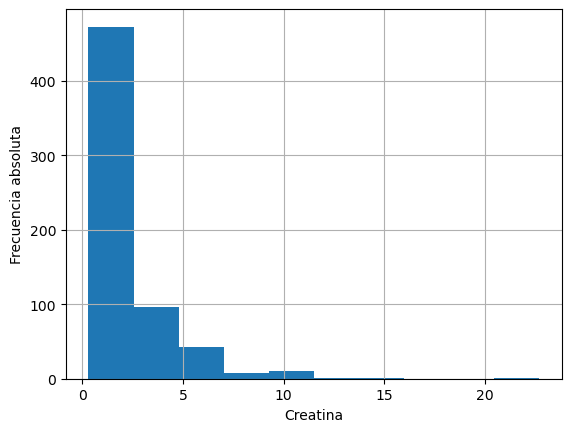

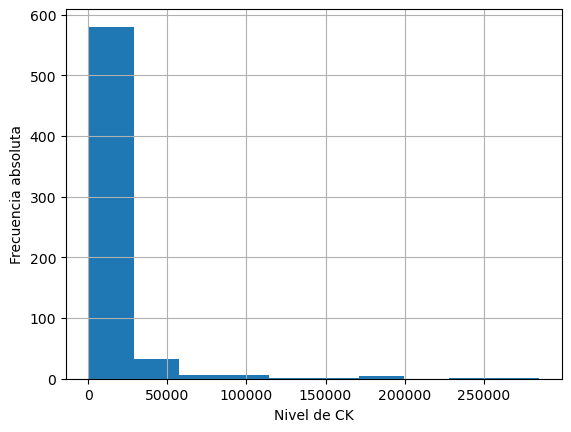

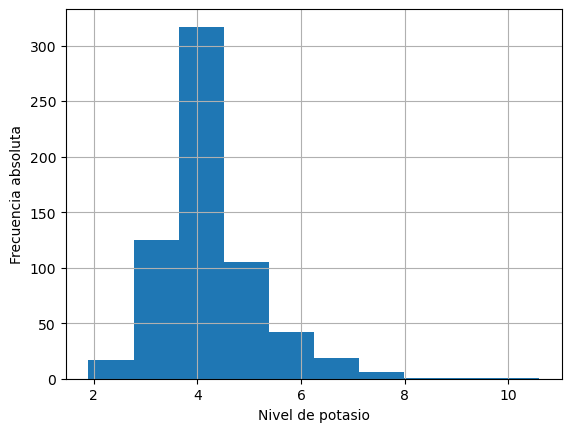

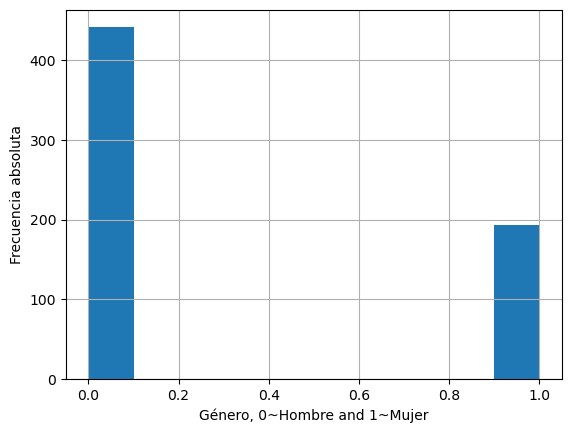

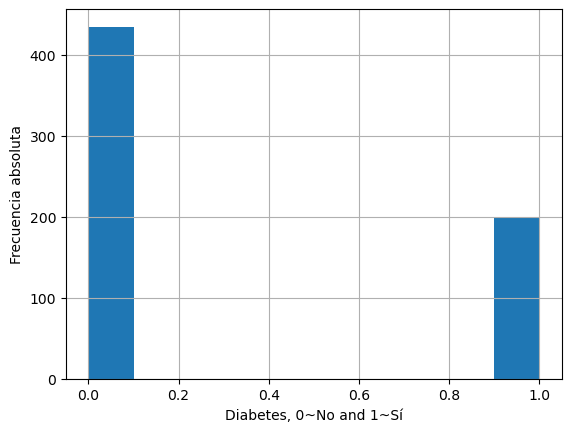

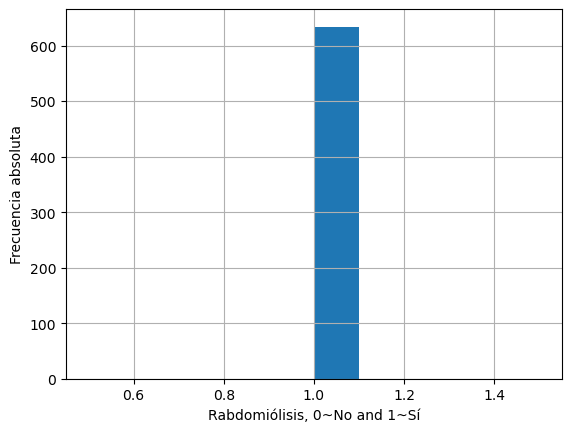

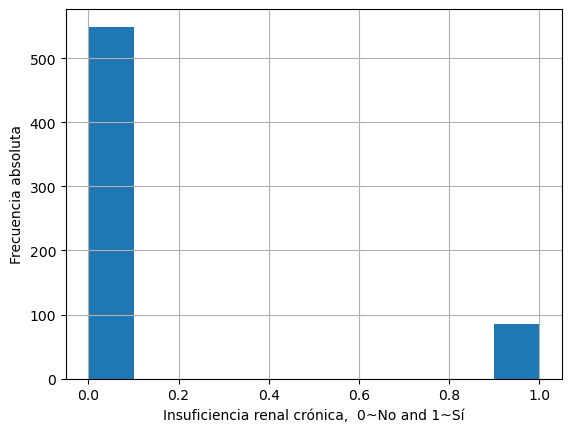

In [30]:
X.describe()# Estadística descriptiva
#Importamos matplotlib.pyplot
import matplotlib.pyplot as plt

print(X.dtypes)#Tipos de las variables

#Seleccionamos el subconjunto entre las columnas del género y el diagnóstico de diabetes 
X = X.loc[:,'SEX':'diab_code']

#Representamos histogramas de frecuencias absolutas para cada variable del conjunto X

X['crea'].hist()
plt.xlabel('Creatina')
plt.ylabel('Frecuencia absoluta')
plt.show()

X['ck'].hist()
plt.xlabel('Nivel de CK')
plt.ylabel('Frecuencia absoluta')
plt.show()

X['potassium'].hist()
plt.xlabel('Nivel de potasio')
plt.ylabel('Frecuencia absoluta')
plt.show()

#Variables categóricas:
X['SEX'].hist()
plt.xlabel('Género, 0~Hombre and 1~Mujer')
plt.ylabel('Frecuencia absoluta')
plt.show()

X['diab_code'].hist()
plt.xlabel('Diabetes, 0~No and 1~Sí')
plt.ylabel('Frecuencia absoluta')
plt.show()
           
X['rhabdomiolisis'].hist()
plt.xlabel('Rabdomiólisis, 0~No and 1~Sí')
plt.ylabel('Frecuencia absoluta')
plt.show()


X['chronickidneydisease'].hist()
plt.xlabel('Insuficiencia renal crónica,  0~No and 1~Sí')
plt.ylabel('Frecuencia absoluta')
plt.show()

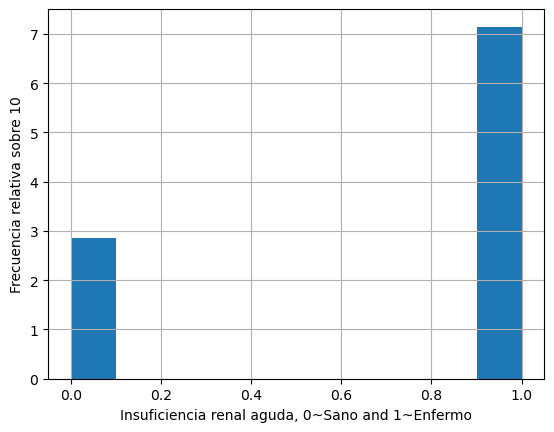

In [31]:
#Histograma de frecuencia relativa de Y(Diagnostico de insuficiencia renal aguda)
y.hist(density = True)
plt.xlabel('Insuficiencia renal aguda, 0~Sano and 1~Enfermo')
plt.ylabel('Frecuencia relativa sobre 10')

plt.show()

### 3. Modelización 

#### 3.1. División de los conjuntos de entrenamiento y test

In [32]:
'''
# unir Las columnas relevantes de Lo tobla de odwisiones dentro de la tabla de pocientes
df = pd.merge(admissions_df, patients_df, on='SUBJECT_ID')
df['DO8'] = pd.to_datetime(df["DOB"])
df['ADMITTIME'] = pd.to_datetime(df[ 'ADMITTIME'])

#caloulor Le edod ol momento de Lo adwisidn
df ['AGE'] = (df['ADMITTIME'].dt.year - df['DOB'].dt.year).astype(float)

# codificar los valores de género
le = LabelEncoder()
df ['GENDER'] = le.fit_transform(df['GENDER'])

# Seleccionar un subconjunto de datos (en este caso uno muestra representative pera crear pocientes)
df_subset = df[['AGE', 'GENDER', 'HOSPITAL_EXPIRE_FLAG']].sample(n=1338)
'''

#Librerías:
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, precision_score, recall_score

#Dividimos los conjuntos de entrenamiento(70%) y test(30). 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)






#### 3.2. Construcción de los modelos con el conjunto de entrenamiento

Probaremos: Random Forest, Logistic Regression, Support Vector Machine, XGBoost y LightGBM 

In [33]:
#Modelos de clasificación
models = dict([("Random Forest", RandomForestClassifier()), 
          ('Logistic Regression', LogisticRegression(max_iter=10000)), 
          ('Support Vector Machine', SVC()),
          ('XGBoost', XGBClassifier()),
          ('LightGBM', LGBMClassifier())])

# Evaluar los modelos utilizando validación cruzada
for name, model in models.items():
    print(f'{name}:')
    # Volidación cruzada
    scores = cross_val_score(model, X_train, y_train, cv=7, scoring = 'balanced_accuracy')
    print(f'Mean cross-validation score: {scores.mean():.3f}')
    print(f'Standard deviation: {scores.std():.3f}')
  
    #Ajuste con train:
    model.fit(X_train, y_train)
    
    #Predicción con test:
    y_pred = model.predict(X_test)
    
    #Resultados
    accuracy = accuracy_score(y_test, y_pred)#Exactitud
    precision = precision_score(y_test, y_pred, average='weighted')#Precisión
    recall = recall_score(y_test, y_pred, average='weighted')
    
    print(f'Accuracy score on test data: {accuracy:.3f}')
    print(f'Precision score on test data: {precision:.3f}')
    print(f'Recall score on test data: {recall:.3f}\n')

#REPETIMOS CON LOS DATOS NORMALIZADOS:
print(' ')
print('With scaled data')
print(' ')
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
normalizer = Normalizer().fit(X)
X_train_scaled=normalizer.transform(X_train_scaled)
X_test_scaled=normalizer.transform(X_test_scaled)

#Utilizamos los mismos modelos:
models = dict([("Random Forest", RandomForestClassifier()), 
          ('Logistic Regression', LogisticRegression(max_iter=10000)), 
          ('Support Vector Machine', SVC()),
          ('XGBoost', XGBClassifier()),
          ('LightGBM', LGBMClassifier())])

# Evaluar los modelos utilizando validación cruzada
for name, model in models.items():
    print(f'{name}:')
    
    # Validación cruzada
    scores = cross_val_score(model, X_train_scaled, y_train, cv=7, scoring='balanced_accuracy')
    print(f'Mean cross-validation score: {scores.mean():.3f}')
    print(f'Standard deviation: {scores.std():.3f}')
    
    model.fit(X_train_scaled, y_train) #Ajuste del modelo a los datos de entrenamiento escalados y las etiquetas. 
    
    #Predicción con los datos test escalados:
    y_pred = model.predict(X_test_scaled)
    
    #Resultados:
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f'Accuracy score on test data: {accuracy:.3f}')
    print(f'Precision score on test data: {precision:.3f}')
    print(f'Recall score on test data: {recall:.3f}\n')

#print(X)


Random Forest:
Mean cross-validation score: 0.816
Standard deviation: 0.055
Accuracy score on test data: 0.874
Precision score on test data: 0.885
Recall score on test data: 0.874

Logistic Regression:
Mean cross-validation score: 0.560
Standard deviation: 0.074
Accuracy score on test data: 0.785
Precision score on test data: 0.775
Recall score on test data: 0.785

Support Vector Machine:
Mean cross-validation score: 0.500
Standard deviation: 0.000


C:\Users\34668\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy score on test data: 0.707
Precision score on test data: 0.500
Recall score on test data: 0.707

XGBoost:
Mean cross-validation score: 0.820
Standard deviation: 0.030
Accuracy score on test data: 0.853
Precision score on test data: 0.853
Recall score on test data: 0.853

LightGBM:
Mean cross-validation score: 0.829
Standard deviation: 0.047
Accuracy score on test data: 0.843
Precision score on test data: 0.849
Recall score on test data: 0.843

 
With scaled data
 
Random Forest:


C:\Users\34668\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  warnings.warn(
C:\Users\34668\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  warnings.warn(


Mean cross-validation score: 0.789
Standard deviation: 0.065
Accuracy score on test data: 0.859
Precision score on test data: 0.866
Recall score on test data: 0.859

Logistic Regression:
Mean cross-validation score: 0.739
Standard deviation: 0.066
Accuracy score on test data: 0.864
Precision score on test data: 0.862
Recall score on test data: 0.864

Support Vector Machine:
Mean cross-validation score: 0.771
Standard deviation: 0.053
Accuracy score on test data: 0.822
Precision score on test data: 0.834
Recall score on test data: 0.822

XGBoost:
Mean cross-validation score: 0.814
Standard deviation: 0.079
Accuracy score on test data: 0.848
Precision score on test data: 0.853
Recall score on test data: 0.848

LightGBM:
Mean cross-validation score: 0.803
Standard deviation: 0.050
Accuracy score on test data: 0.827
Precision score on test data: 0.838
Recall score on test data: 0.827



array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'2'}>],
       [<AxesSubplot:title={'center':'3'}>,
        <AxesSubplot:title={'center':'4'}>,
        <AxesSubplot:title={'center':'5'}>],
       [<AxesSubplot:title={'center':'6'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

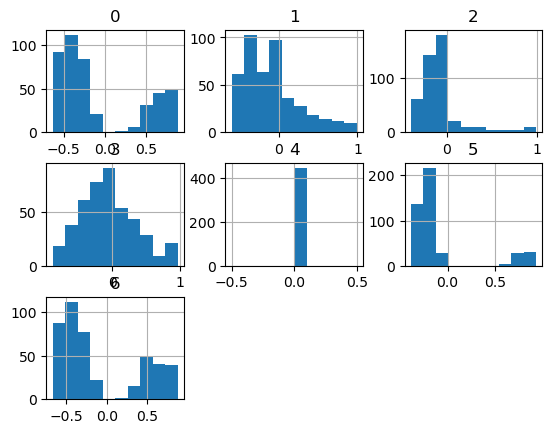

In [34]:
#Histograma de frecuencias absolutas del conjunto de entrenamiento escalado
pd.DataFrame(X_train_scaled).hist()

array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'2'}>],
       [<AxesSubplot:title={'center':'3'}>,
        <AxesSubplot:title={'center':'4'}>,
        <AxesSubplot:title={'center':'5'}>],
       [<AxesSubplot:title={'center':'6'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

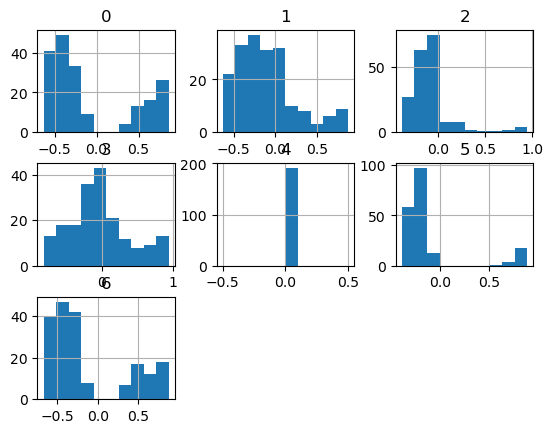

In [35]:
#Histograma de frecuencias absolutas del conjunto de prueba escalado
pd.DataFrame(X_test_scaled).hist()

In [36]:
#Separamos los conjuntos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Validación cruzada
model = XGBClassifier()
scores = cross_val_score(model, X_train, y_train, cv=7, scoring = 'accuracy')
print(f'Mean cross-validation score: {scores.mean():.3f}')
print(f'Standard deviation: {scores.std():.3f}')

# Datos de entrenamiento
model.fit(X_train, y_train)

#Predicción
y_pred = model.predict(X_test)

#Resultados
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print(f'Accuracy score on test data: {accuracy:.3f}')
print(f'Precision score on test data: {precision:.3f}')
print(f'Recall score on test data: {recall:.3f}\n')

Mean cross-validation score: 0.853
Standard deviation: 0.025
Accuracy score on test data: 0.853
Precision score on test data: 0.853
Recall score on test data: 0.853



#### 3.3. Evaluación del modelo: XGBoost

In [37]:
#Separamos los conjuntos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Validación cruzada
model = XGBClassifier()
scores = cross_val_score(model, X_train, y_train, cv=7, scoring = 'accuracy')
print(f'Mean cross-validation score: {scores.mean():.3f}')
print(f'Standard deviation: {scores.std():.3f}')

# Datos de entrenamiento
model.fit(X_train, y_train)

#Predicción
y_pred = model.predict(X_test)

#Resultados
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print(f'Accuracy score on test data: {accuracy:.3f}')
print(f'Precision score on test data: {precision:.3f}')
print(f'Recall score on test data: {recall:.3f}\n')

Mean cross-validation score: 0.853
Standard deviation: 0.025
Accuracy score on test data: 0.853
Precision score on test data: 0.853
Recall score on test data: 0.853



In [38]:
from sklearn.metrics import confusion_matrix

# Suponiendo: etiquetas predichas 'y_pred' y etiquetas verdaderas 'y_true' computamos la herramienta
cm = confusion_matrix(y_test, y_pred)

# Mostramos la matriz de confusión
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[ 42  14]
 [ 14 121]]


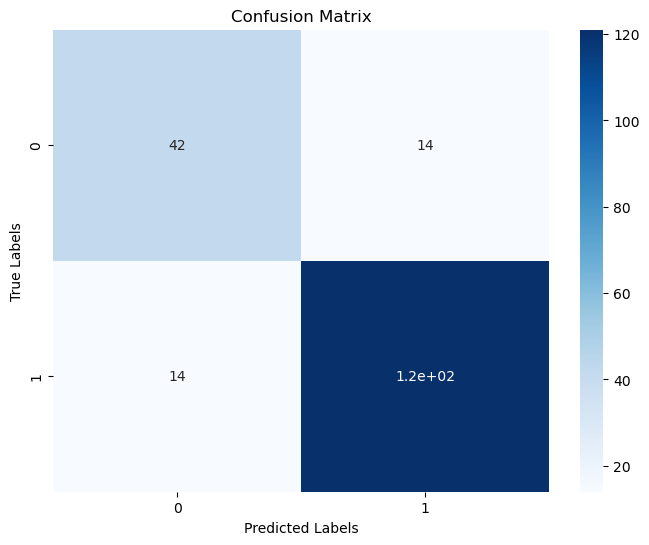

In [39]:
#La representamos gráficamente:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have predicted labels 'y_pred' and true labels 'y_true'
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


De la matriz de confusión podemos determinar que:
   
Pacientes clasificados correctamente: 162
   - Pacientes que no desarrollan insuficiencia renal aguda (TN): 42
   - Pacientes que sí desarrollan insufciencia renal aguda (TP): 120
 
Pacientes clasificados incorrectamente: 29
   - Clasificados como no pero sí desarrollan la insuficiencia renal aguda (FN): 14
   - Clasificados como sí pero no desarrollan la insuficiencia renal aguda (FP): 15


En definitiva, hemos entrenado un modelo XGBoost con buena capacidad para detectar pacientes que desarrollarán insuficiencia renal aguda por rabdomiólisis. 